### 1. Import packages

Importing required modules and setting random seed

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import model_selection as ms
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

SEED = 42

### 2. Data preparation

#### 2.1 Loading Wine dataset

In [2]:
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/" "machine-learning-databases/wine/wine.data",
    header=None,
)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


#### 2.2 Splitting the data

In [3]:
X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values
X, y

(array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
         1.185e+03],
        ...,
        [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
         8.350e+02],
        [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
         8.400e+02],
        [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
         5.600e+02]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
 

In [4]:
X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((142, 13), (142,), (36, 13), (36,))

#### 2.3 Scaling the data

In [5]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 3. PCA Implementation

#### 3.1 Computing covariance matrix

In [6]:
cov_matrix = np.cov(X_train_scaled.T)
cov_matrix.shape

(13, 13)

At the intersection of $i^{th}$ row and $j^{th}$ column will lay the covariance between $i^{th}$ and $j^{th}$ features:  

$\normalsize \sigma_{ij} = \frac {1}{N-1} \sum_{k = 1}^{N} {(x^{(k)}_i - \mu_i)(x^{(k)}_j - \mu_j)}$  

Here, $\mu_i$ and $\mu_j$ are the sample means of features i and j, respectively.   
Note that the sample means are zero if we standardized the dataset.  
A positive covariance between two features indicates that the features increase or decrease together, whereas a negative covariance indicates that the feature  vary in opposite directions.  

For example, the covariance matrix of three features can then be written as follows:  
$\sum = \begin{bmatrix}
\sigma_{1}^2 & \sigma_{12} & \sigma_{13}\\
\sigma_{21} & \sigma_{2}^2 & \sigma_{23}\\
\sigma_{31} & \sigma_{32} & \sigma_{3}^2
\end{bmatrix}$

#### 3.2 Decomposing the covariance matrix into its eigenvectors and eigenvalues

The eigenvectors of the covariance matrix represent the principal components (the directions of maximum variance), whereas the corresponding eigenvalues will define their magnitude.

In [7]:
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)
eigen_values.shape, eigen_vectors.shape

((13,), (13, 13))

Eigenvector, $v$, satisfies the following condition:  

$\normalsize \sum v = \lambda v$  

Here, $\lambda$ is a scalar: the eigenvalue.

Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace, we only select the subset of the eigenvectors (principal components) that contains most of the information (variance).  

The eigenvalues define the magnitude of the eigenvectors, so we have to sort the eigenvalues by decreasing magnitude; we are interested in the top-$k$ eigenvectors based on the values of their corresponding eigenvalues. 

But before we collect those k most informative eigenvectors, let's plot the variance explained ratios of the eigenvalues. 
The variance explained ratio of an eigenvalue, $\lambda_i$, is simply the fraction of an eigenvalue, $\lambda_i$, and the total sum of the eigenvalues:  

$\normalsize \text{Explained variance ratio} = \frac {\lambda_i} {\sum_{i = j}^{d} {\lambda_j}}$

In [8]:
var_explained = np.array(
    [var / np.sum(eigen_values) for var in sorted(eigen_values, reverse=True)]
)
var_explained

array([0.35792104, 0.19270671, 0.11019835, 0.07272276, 0.06721919,
       0.05131943, 0.04377423, 0.02500853, 0.0227943 , 0.01877102,
       0.01781765, 0.01256721, 0.00717958])

In [9]:
cum_var_explained = np.cumsum(var_explained)
cum_var_explained

array([0.35792104, 0.55062776, 0.66082611, 0.73354887, 0.80076806,
       0.85208748, 0.89586171, 0.92087024, 0.94366454, 0.96243556,
       0.98025321, 0.99282042, 1.        ])

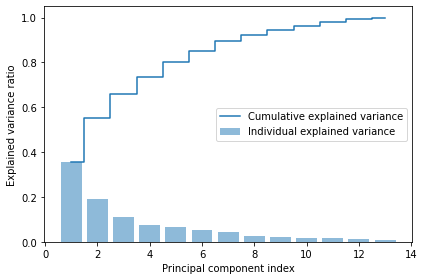

In [10]:
plt.bar(
    range(1, len(var_explained) + 1),
    var_explained,
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
plt.step(
    range(1, len(cum_var_explained) + 1),
    cum_var_explained,
    where="mid",
    label="Cumulative explained variance",
)
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

The resulting plot indicates that the first principal component alone accounts for approximately 40 percent of the variance.  

Also, we can see that the first two principal components combined explain almost 60 percent of the variance in the dataset.

#### 3.3 Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.

In [11]:
eigen_pairs = [
    (np.abs(eigen_values[i]), eigen_vectors[:, i]) for i in range(len(eigen_values))
]
eigen_pairs.sort(key=lambda item: item[0], reverse=True)
eigen_pairs

[(4.685973384295744,
  array([ 0.14437334, -0.2337447 ,  0.00706511, -0.2235901 ,  0.15184439,
          0.39439159,  0.429506  , -0.29140435,  0.31334896, -0.09640988,
          0.29685959,  0.38316219,  0.28993558])),
 (2.522954566300952,
  array([-0.4869468 , -0.22289583, -0.31157842,  0.03897025, -0.2964377 ,
         -0.07626637,  0.00253396, -0.0208294 , -0.01090402, -0.52442852,
          0.29752402,  0.17026267, -0.35751114])),
 (1.442738686113919,
  array([-0.15569954,  0.06354546,  0.63847042,  0.64069029,  0.10018241,
          0.14420429,  0.10002901,  0.18497553,  0.15636423, -0.13309435,
          0.11983753,  0.11586375, -0.09267495])),
 (0.9521007782561318,
  array([ 0.20988404, -0.50184037,  0.19895738, -0.08732155, -0.26768798,
         -0.04492907, -0.05077208,  0.45843691, -0.37659306,  0.04511203,
          0.38035231, -0.06777416,  0.27813578])),
 (0.8800469857887143,
  array([-0.19581265, -0.3618969 ,  0.01492415,  0.02967618,  0.75640337,
         -0.25806712, -

#### 3.4 Select $k$ eigenvectors, which correspond to the $k$ largest eigenvalues

Where $k$ is the dimensionality of the new feature subspace $k \leq d$ ($d$ - original dimensionality)

In [12]:
k = 2
print(
    f"{k} principal components account for approximately {cum_var_explained[k - 1].round(1)} percent of variance"
)

2 principal components account for approximately 0.6 percent of variance


In [13]:
eigen_pairs[:k]

[(4.685973384295744,
  array([ 0.14437334, -0.2337447 ,  0.00706511, -0.2235901 ,  0.15184439,
          0.39439159,  0.429506  , -0.29140435,  0.31334896, -0.09640988,
          0.29685959,  0.38316219,  0.28993558])),
 (2.522954566300952,
  array([-0.4869468 , -0.22289583, -0.31157842,  0.03897025, -0.2964377 ,
         -0.07626637,  0.00253396, -0.0208294 , -0.01090402, -0.52442852,
          0.29752402,  0.17026267, -0.35751114]))]

#### 3.5 Construct a projection matrix, $\textbf{W}$, from the "top" $k$ eigenvectors

In [14]:
w = np.hstack(
    [eigen_vector.reshape(-1, 1) for eigen_value, eigen_vector in eigen_pairs[:k]]
)

In [15]:
print("Projection matrix W:\n", w)

Projection matrix W:
 [[ 0.14437334 -0.4869468 ]
 [-0.2337447  -0.22289583]
 [ 0.00706511 -0.31157842]
 [-0.2235901   0.03897025]
 [ 0.15184439 -0.2964377 ]
 [ 0.39439159 -0.07626637]
 [ 0.429506    0.00253396]
 [-0.29140435 -0.0208294 ]
 [ 0.31334896 -0.01090402]
 [-0.09640988 -0.52442852]
 [ 0.29685959  0.29752402]
 [ 0.38316219  0.17026267]
 [ 0.28993558 -0.35751114]]


#### 3.6 Transform the $d$-dimensional input dataset, $\textbf{X}$, using the projection matrix, $\textbf{W}$, to obtain the new $k$-dimensional feature subspace.

Using the projection matrix, we can now transform the entire $124×13$-dimensional training dataset onto the two principal components by calculating the matrix dot product:  
$X' = XW$

In [16]:
X_train_pca = X_train_scaled.dot(w)
X_train_pca.shape

(142, 2)

#### 3.7 Visualisation

In [17]:
def plot_2_pca(X_train_pca, y_train):
    colors = ["r", "b", "g"]
    markers = ["o", "s", "^"]
    for l, c, m in zip(np.unique(y_train), colors, markers):
        plt.scatter(
            X_train_pca[y_train == l, 0],
            X_train_pca[y_train == l, 1],
            c=c,
            label=f"Class {l}",
            marker=m,
        )
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

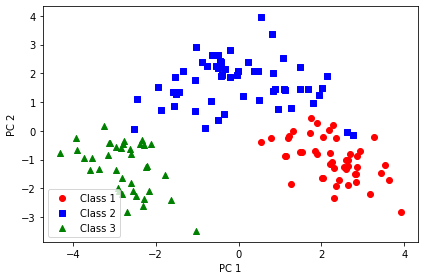

In [18]:
plot_2_pca(X_train_pca, y_train)

As we can see, the data is more spread along the first principal component (x axis) than the second principal component (y axis), which is consistent with the explained variance ratio plot that we created in the previous subsection.  
However, we can tell that a linear classifier will likely be able to separate the classes well.

### 4.1 Sklearn Implementation

In [19]:
pca = PCA()
X_train_pca_sklearn = pca.fit_transform(X_train_scaled)
pca.explained_variance_ratio_

array([0.35792104, 0.19270671, 0.11019835, 0.07272276, 0.06721919,
       0.05131943, 0.04377423, 0.02500853, 0.0227943 , 0.01877102,
       0.01781765, 0.01256721, 0.00717958])

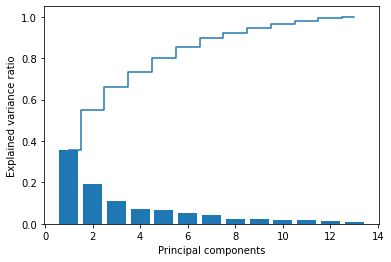

In [20]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, align="center")
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where="mid")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")

plt.show()

In [21]:
pca = PCA(n_components=2)
X_train_pca_sklearn = pca.fit_transform(X_train_scaled)

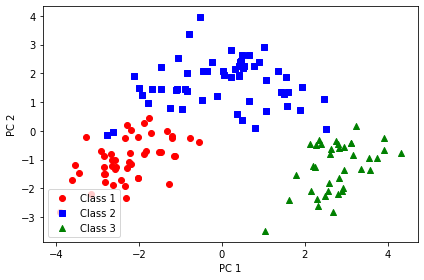

In [22]:
plot_2_pca(X_train_pca_sklearn, y_train)